# Optimizing a Harmonic Synthesizer

In this section we look at using gradient descent to learn parameters for a harmonic
synthesizer to match an instrumental sound.

We'll define a harmonic synthesizer which has the following additions, which are taken
directly from {cite:t}`engel_ddsp_2020`:
1) constraining harmonic amplitudes to
sum to one; 
2) adding a global amplitude parameter; 
3) parameter scaling to constrain the possible range of amplitudes;
4) removing frequencies above the Nyquist frequency which will result in aliasing;
5) interpolation of parameters from frame rate to sample rate.

The updated formula for our harmonic synthesizer is:

$$
    y[n] = A[n]\sum_{k=1}^{K}\hat{\alpha}_k[n]\sin\left(k\sum_{m=0}^{n}\omega_{0}[m]\right)
$$

where $A[n]$ is a global amplitude parameter, and $\hat{\alpha}_k[n]$ is the normalized
amplitude for the $k^{\text{th}}$ sinusoidal component. $\hat{\alpha}_k[n]$ is normalized
such that $\sum_{k}\hat{\alpha}_k[n] = 1$ and $\hat{\alpha}_k[n] > 0$. Fundamental frequency $\omega_{0}[n]$ is pre-computed using a pitch extraction algorithm.
Methods for parameter scaling and removing frequencies above the Nyquist frequency will be introduced inline below.

Instead of specifying parameters at a resolution equivalent to the audio sampling rate we'll use a frame rate of 100Hz.
This sets a reasonable upper bound on the frequency of change of our control signals and has
the added benefit of decreasing the dimensionality of the optimization problem. We only
need to learn \~200 values per harmonic for a second of audio at 16kHz instead of 16k!

Finally, we'll use gradient descent with a spectral loss function to match sounds from 
the [NSynth test dataset](https://magenta.tensorflow.org/datasets/nsynth#files) {cite:p}`engel2017neural`.

In [1]:
import math

import torch
import torchaudio
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.animation import FuncAnimation
import IPython.display as ipd

import auraloss

_ = torch.manual_seed(0)

## Parameter Scaling

Before writing the harmonic synth we'll define some helper functions.

The first is a scaling function that is used to constrain parameter outputs to a particular range
while providing stable and informative gradients for a wide range of input values.

In [2]:
@torch.jit.script
def scale_function(
    x: torch.Tensor,
    exponent: float = 10.0,
    max_value: float = 2.0,
    threshold: float = 1e-7,
):
    """
    Scales a parameter to a range of [threshold, max_value] with a slope of exponent.
    A threshold is used to stabilize the gradient near zero.
    """
    return max_value * torch.sigmoid(x) ** math.log(exponent) + threshold

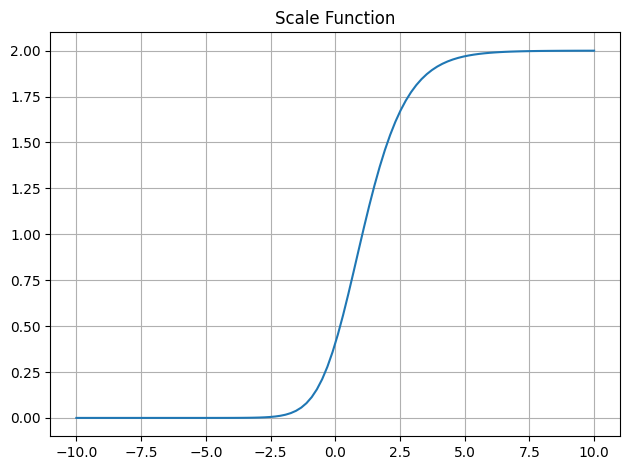

In [3]:
x = torch.linspace(-10.0, 10.0, 100)

plt.plot(x, scale_function(x))
plt.grid()
plt.title("Scale Function")
plt.tight_layout()
plt.show()

## Aliasing

The second function removes any frequencies above the Nyquist frequency, which will be
incorrectly represented (i.e, aliased). This zeros out the amplitudes of any frequencies
above the Nyquist frequency.

In [4]:
@torch.jit.script
def remove_above_nyquist(
    harmonic_amps: torch.Tensor,
    frequencies: torch.Tensor,
):
    return harmonic_amps * (frequencies < torch.pi).float()

To see what aliasing looks like consider a frequency envelope that goes from 0Hz to the
the sample rate $f_s$ over one second. Remember that the Nyquist frequency is $f_s / 2$.

In [5]:
freq = torch.linspace(0.0, 2.0 * math.pi, 16000)
amps = torch.ones_like(freq)

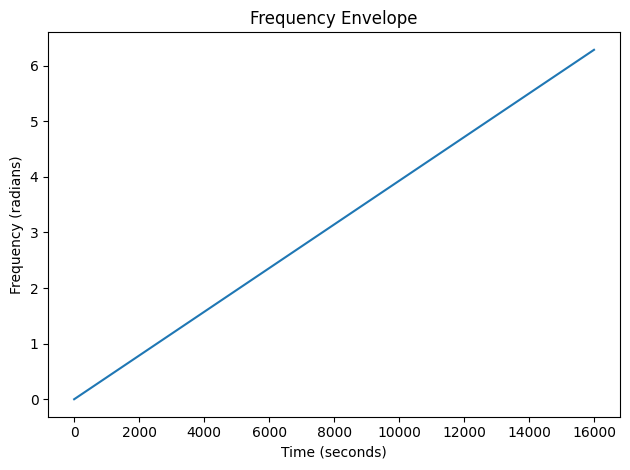

In [6]:
plt.plot(freq)
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (radians)")
plt.title("Frequency Envelope")
plt.tight_layout()
plt.show()

In [7]:
# Helper function to plot a spectrogram with log-scaled frequency axis
def plot_spectrogram(
    x: torch.Tensor, sample_rate: int, fig: plt.Figure = None, ax: plt.Axes = None
):
    n_fft = 2048
    hop_length = 512
    X = torch.stft(
        x,
        n_fft=n_fft,
        hop_length=hop_length,
        return_complex=True,
        window=torch.hann_window(n_fft),
    )

    # Convert to decibels
    X_mag = torch.abs(X)
    X_db = 20.0 * torch.log10(X_mag + 1e-6)

    # Get frequencies for each FFT bin in hertz
    fft_freqs = torch.abs(torch.fft.fftfreq(2048, 1 / sample_rate)[: X_db.shape[1]])

    # Time in seconds for each frame
    times = torch.arange(X_db.shape[-1]) * hop_length / sample_rate

    # Plot the spectrogram
    if fig is None and ax is None:
        fig, ax = plt.subplots()

    ax.pcolormesh(times, fft_freqs, X_db[0].numpy())

    # Set the y-axis to log scale
    ax.set_yscale("symlog", base=2.0)
    ax.set_ylim(40.0, 8000.0)

    ax.yaxis.set_major_formatter(mplticker.ScalarFormatter())
    ax.yaxis.set_label_text("Frequency (Hz)")

    ax.xaxis.set_major_formatter(mplticker.ScalarFormatter())
    ax.xaxis.set_label_text("Time (Seconds)")

    return fig, ax, times, fft_freqs

The frequency envelope linearly increases over one second, but when we listen to it
and plot the spectrogram we see something different! What happened?? All frequencies
above $\pi$ (Nyquist) have aliased, which we see as wrapping around the Nyquist frequency.

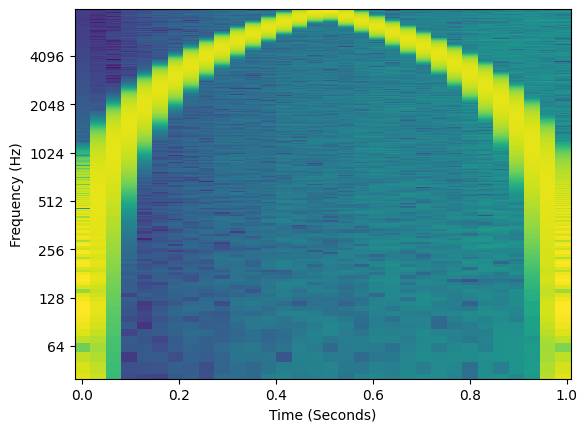

In [8]:
y = amps * torch.sin(torch.cumsum(freq, dim=-1))
plot_spectrogram(y.unsqueeze(0), 16000)
ipd.Audio(y, rate=16000)

When we remove frequencies above the Nyquist frequency we get rid of the second half
of the signal that was aliasing.

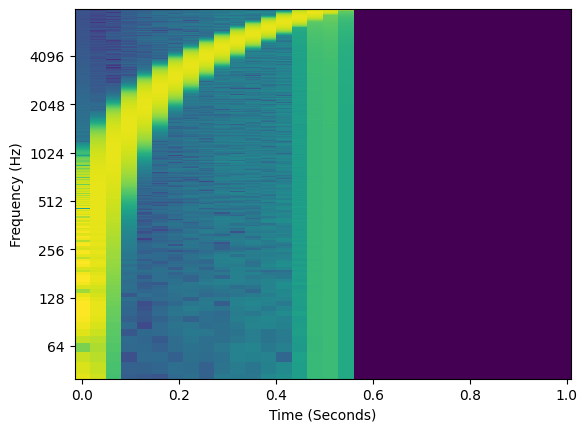

In [9]:
amps = remove_above_nyquist(amps, freq)
y = amps * torch.sin(torch.cumsum(freq, dim=-1))

plot_spectrogram(y.unsqueeze(0), 16000)
ipd.Audio(y, rate=16000)

## Updated Harmonic Synthesizer

This function should be familiar from the previous section. Here we calculate $K$ (`num_harmonics`)
frequencies in relation to a fundamental frequency.

In [10]:
@torch.jit.script
def get_harmonic_frequencies(f0: torch.Tensor, num_harmonics: int):
    # Create integer harmonic ratios and reshape to (1, n_harmonics, 1) so we can
    # multiply with fundamental frequency tensor repeated for num_harmonics
    harmonic_ratios = torch.arange(1, num_harmonics + 1).view(1, -1, 1)

    # Duplicate the fundamental frequency for each harmonic
    frequency = f0.unsqueeze(1).repeat(1, num_harmonics, 1)

    # Multiply the fundamental frequency by the harmonic ratios
    frequency = frequency * harmonic_ratios

    return frequency

We've made one minor change to `additive_synth`. We now expect to receive frequency and
amplitude tensors that are time-varying at a frame rate. In this function we now upsample
from the frame rate to the audio sample rate using linear interpolation (`torch.nn.functional.interpolate`) prior to synthesis.

In [11]:
@torch.jit.script
def additive_synth(
    frequencies: torch.Tensor,  # Angular frequencies (rad / sample) - frame rate
    amplitudes: torch.Tensor,  # Amplitudes
    n_samples: int,  # Number of samples to synthesize
):
    assert (
        frequencies.ndim == 3
    ), "Frequencies must be 3D (batch, n_frequencies, n_frames)"
    assert (
        frequencies.shape == amplitudes.shape
    ), "Frequency and amplitude shapes must match"

    # Upsample frequency and amplitude envelopes to sample rate
    f_up = torch.nn.functional.interpolate(frequencies, size=n_samples, mode="linear")
    a_up = torch.nn.functional.interpolate(amplitudes, size=n_samples, mode="linear")

    # Set initial phase to zero, prepend to frequency envelope
    initial_phase = torch.zeros_like(f_up[:, :, :1])
    f_up = torch.cat([initial_phase, f_up], dim=-1)[..., :-1]

    # Create the phase track and remove the last sample (since we added initial phase)
    phase = torch.cumsum(f_up, dim=-1)

    y = torch.sin(phase) * a_up
    y = torch.sum(y, dim=1)

    return y

Our `harmonic_synth` has been updated to accept a `global_amp` parameter (i.e, $A[n]$)
and the expected number of samples at the output, which is used to upsample from frame
rate to sample rate.

We also apply the scaling function to both amplitude parameters, remove frequencies above
the Nyquist frequency, and normalize harmonic amplitudes to a distribution.

In [12]:
@torch.jit.script
def harmonic_synth(
    f0: torch.Tensor,  # Angular fundamental frequency (batch, n_samples)
    global_amp: torch.Tensor,  # Global amplitude (batch, n_samples)
    harmonic_amps: torch.Tensor,  # Amplitudes of harmonics (batch, n_harmonics, n_samples)
    num_samples: int,  # Number of samples to synthesize
):
    assert f0.ndim == 2, "Fundamental frequency must be 2D (batch, n_samples)"
    assert (
        harmonic_amps.ndim == 3
    ), "Harmonic amplitudes must be 3D (batch, n_harmonics, n_samples)"

    # Get the harmonic frequencies
    frequency = get_harmonic_frequencies(f0, harmonic_amps.shape[1])

    # Scale the amplitudes
    harmonic_amps = scale_function(harmonic_amps)
    global_amp = scale_function(global_amp)

    # Remove frequencies above Nyquist
    harmonic_amps = remove_above_nyquist(harmonic_amps, frequency)

    # Normalize the harmonic amplitudes
    harmonic_amps = harmonic_amps / torch.sum(harmonic_amps, dim=1, keepdim=True)

    # Multiply all harmonic amplitudes by the global amplitude
    harmonic_amps = harmonic_amps * global_amp.unsqueeze(1)

    return additive_synth(frequency, harmonic_amps, num_samples)

## Sound Matching with Gradient Descent

Now we've defined our harmonic synthesizer with the added functionality to more closely
mimic the one specified by {cite:t}`engel_ddsp_2020`.

Let's try to replicate this saxophone sound!

In [13]:
# Load audio
audio, sample_rate = torchaudio.load("../_static/audio/reed_acoustic_011-045-050.wav")

# Extract the first 2.0 seconds of the audio
audio = audio[:1, : int(sample_rate * 2.0)]
ipd.Audio(audio.numpy(), rate=sample_rate)

We first need to determine the fundamental frequency envelope. Engel et al. used
crepe {cite:p}`kim2018crepe`, which is a deep learning model trained for pitch extraction.

For this example, we'll just use torchaudio's built-in pitch detection to keep things simple.
In the next section we'll share some results using crepe.

In [14]:
# Set parameters to have a frame rate of 100 Hz
f0 = torchaudio.functional.detect_pitch_frequency(
    audio, sample_rate, frame_time=0.0093, win_length=30
)

frame_rate = f0.shape[-1] / (audio.shape[-1] / sample_rate)
print(f"Frame rate: {frame_rate:.2f} Hz")

Frame rate: 100.00 Hz


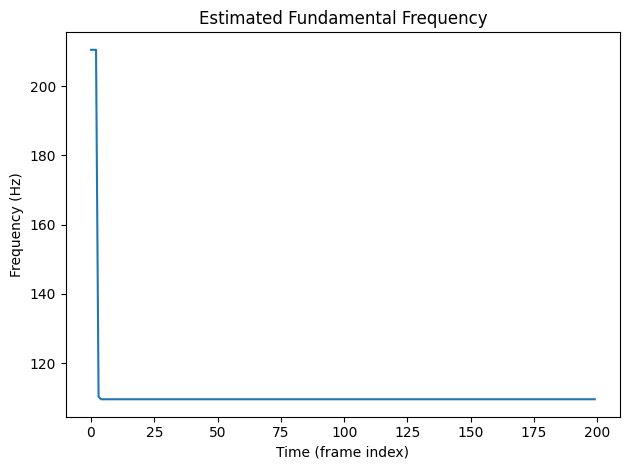

In [15]:
plt.plot(f0[0, :].numpy())
plt.title("Estimated Fundamental Frequency")
plt.xlabel("Time (frame index)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

We can see in the fundamental frequency plot the pitch detection algorithm has estimated
an extremely high value for pitch during the onset. This is an error and will be reflected in
the synthesized results. But for demonstration purposes this will work just fine!

If we look at the fundamental frequency envelope after the onset there is a stable fundamental
frequency of about ~110Hz, which corresponds to a pitch of A2.

Mean fundamental frequency: 109.59 Hz


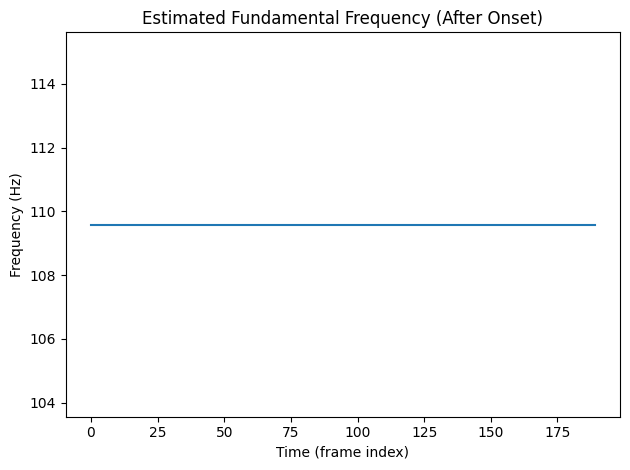

In [16]:
print(f"Mean fundamental frequency: {f0[0,10:].mean():.2f} Hz")

plt.plot(f0[0, 10:].numpy())
plt.title("Estimated Fundamental Frequency (After Onset)")
plt.xlabel("Time (frame index)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

### Fundamental frequency with the spectrogram

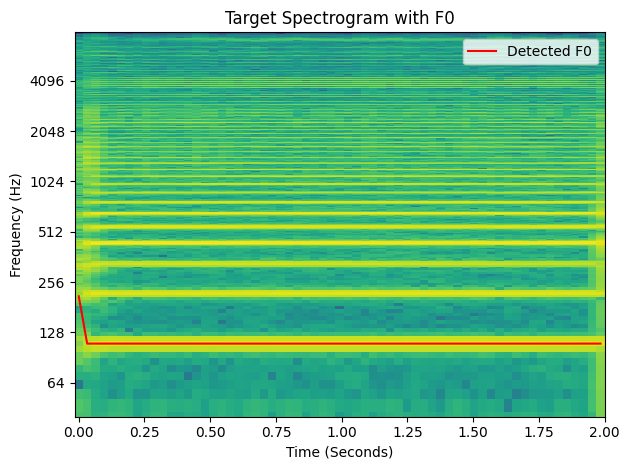

In [17]:
fig, ax, xaxis, yaxis = plot_spectrogram(audio, sample_rate)

f0_interp = f0.unsqueeze(0)
f0_interp = torch.nn.functional.interpolate(
    f0_interp, size=xaxis.shape[0], mode="linear"
)
ax.plot(xaxis, f0_interp[0, 0].numpy(), color="red", label="Detected F0")

ax.legend()
ax.set_title("Target Spectrogram with F0")
fig.tight_layout()
plt.show()

## Spectral Loss

Before we start optimization we need to define our loss function. A phase variant loss
like $L_1$ on the waveform won't work here as we're not expecting our synthesizer to be able to match
phase. Besides, we're focusing on matching sinusoidal components, which is much better handled
in the frequency domain.

Recall the spectral loss function we used in the previous chapter which computed the
$L_1$ loss on magnitude spectrums. This provided a phase-invariant audio loss.

Here, we extend this spectral loss to use the short-time Fourier transform, which computes
the FFT on small chunks of audio input and allows for time-varying frequency changes to
be captured.

Engel et al. used a combination of log magnitude and linear magnitude spectral loss, these
are defined as follows:

### Log magnitude spectral loss
$$
    \mathcal{L}_\text{log}(\mathbf{y}, \hat{\mathbf{y}}) = \left\lVert \log\left| STFT(\mathbf{y}) \right| - \log\left| STFT(\hat{\mathbf{y}}) \right| \right\rVert_{1}
$$

### Linear magnitude spectral loss
$$
    \mathcal{L}_\text{lin}(\mathbf{y}, \hat{\mathbf{y}}) = \left\lVert \left| STFT(\mathbf{y}) \right| - \left| STFT(\hat{\mathbf{y}}) \right| \right\rVert_{1}
$$

where $\left\lVert \cdot \right\rVert_1$ denotes the $L_1$ norm and $\left|STFT(\cdot)\right|$ is the magnitude spectrogram from the short-time Fourier transform. Spectral convergence {cite:p}`arik2018fast` is another spectral loss that is commonly used but not included in here.

## Multiresolution Spectral Loss
{cite:t}`wang2019neural` proposed computing a spectral loss using multiple STFT window sizes and hop lengths, aggregating the outputs into a single loss value. This technique has since come to be known as the *multi-resolution STFT* (MRSTFT) or *multi-scale spectral loss* (MSS) loss.
The motivation behind this formulation is to compensate for the time-frequency resolution tradeoff inherent to the STFT.

A general form for MRSTFT losses is a weighted sum of the different spectral loss formulations at different resolutions:

$$
    \mathcal{L}_\text{MRSTFT} = \sum_{k\in{K}}{\alpha_\text{log}\mathcal{L}_{\text{log},k} + \alpha_\text{lin}\mathcal{L}_{\text{lin},k}}
$$

where $K$ is the set of STFT configurations, $\mathcal{L}_{\cdot,k}$ is a spectral loss computed with a particular configuration, and $\alpha$ is the weighting for a loss term.

Engel et al. used a selection of FFT sizes ranging from 64 to 2048 samples with 75\% overlap. Let's see what this looks like using the [auraloss](https://github.com/csteinmetz1/auraloss) package 

In [18]:
n_ffts = [2048, 1024, 512, 256, 128, 64]
hop_sizes = [n // 4 for n in n_ffts]
loss_fn = auraloss.freq.MultiResolutionSTFTLoss(
    fft_sizes=n_ffts,
    hop_sizes=hop_sizes,
    win_lengths=n_ffts,
    w_sc=0.0,
    w_lin_mag=1.0,
    w_log_mag=1.0,
)

## Optimization

Now we just need to setup the parameters for optimization - global amplitude $A[n]$ and
the harmonic amplitudes $\alpha_k[n]$. For this example we'll set $K=80$.

In [19]:
# Convert fundamental frequency to angular frequency
w0 = f0 * 2 * torch.pi / sample_rate

# Create a harmonic amplitude envelope
num_harmonics = 80
harmonic_amplitudes = torch.randn(1, num_harmonics, f0.shape[-1])

# Create PyTorch parameters - these are the variables we will optimize
harmonic_amplitudes = torch.nn.Parameter(harmonic_amplitudes)
global_amp = torch.nn.Parameter(torch.randn_like(w0))

In [20]:
optimizer = torch.optim.Adam([harmonic_amplitudes, global_amp], lr=0.05)

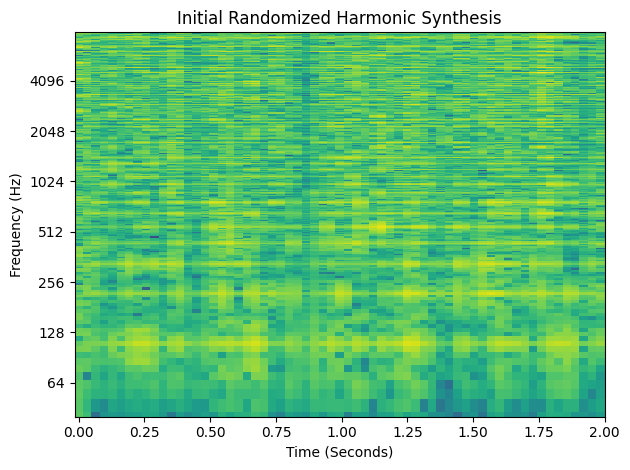

In [21]:
y_hat = harmonic_synth(w0, global_amp, harmonic_amplitudes, audio.shape[-1])
fig, ax, *_ = plot_spectrogram(y_hat.detach(), sample_rate)

ax.set_title("Initial Randomized Harmonic Synthesis")
plt.tight_layout()
plt.show()

Run the optimization loop!

In [22]:
loss_log = []
audio_log = []
for i in range(1000):
    # Forward pass
    y_pred = harmonic_synth(w0, global_amp, harmonic_amplitudes, audio.shape[-1])

    # Compute loss
    loss = loss_fn(audio.unsqueeze(0), y_pred.unsqueeze(0))
    loss_log.append(loss.item())

    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log audio and loss
    if i % 50 == 0:
        audio_log.append(y_pred.detach().cpu().numpy())

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig, im_ax, *_ = plot_spectrogram(y_hat.detach(), sample_rate, fig=fig, ax=axes[0])

axes[1].set_ylim(0.0, max(loss_log))
axes[1].set_xlim(0, len(loss_log))

(line,) = axes[1].plot([], [], lw=2)

num_frames = len(audio_log)


def animate(i):
    iteration = i * 50
    im_ax.set_title(f"Harmonic Synthesis Iteration: {iteration}")
    _ = plot_spectrogram(torch.from_numpy(audio_log[i]), sample_rate, fig=fig, ax=im_ax)
    axes[1].set_title("Loss: {:.4f}".format(loss_log[iteration]))
    line.set_data(torch.arange(iteration), loss_log[:iteration])
    return (line,)


# Create the animation
anim = FuncAnimation(fig, animate, frames=len(audio_log), interval=250, blit=True)

plt.close(fig)
# To display the animation in the Jupyter notebook:
display(ipd.HTML(anim.to_html5_video()))

In [24]:
print("Resulting Harmonic Synthesis:")
ipd.display(ipd.Audio(y_pred[0].detach().numpy(), rate=sample_rate))

print("Target Audio:")
ipd.display(ipd.Audio(audio[0].detach().numpy(), rate=sample_rate))

Resulting Harmonic Synthesis:


Target Audio:


You can hear the outlier pitch at the onset as a squelch, but the steady part of the signal
has been matched pretty well!

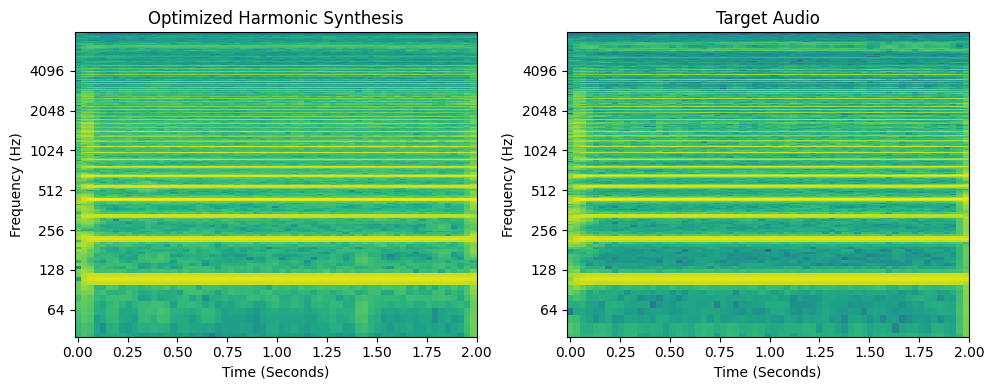

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

_ = plot_spectrogram(y_pred.detach(), sample_rate, fig, axes[0])
_ = plot_spectrogram(audio, sample_rate, fig, axes[1])

axes[0].set_title("Optimized Harmonic Synthesis")
axes[1].set_title("Target Audio")

plt.tight_layout()
plt.show()

## Summary

We've successfully written a differentiable harmonic synthesizer in PyTorch that is capable
of learning to match an acoustic instumental sound! In this notebook we introduced a number
of additions to the basic harmonic synth based on Engel et al.'s differentiable harmonic synthesizer
which helped us in this process. A mutli-resolution STFT loss was then used to optimize the
amplitude parameters to match those of a target sound.

In the next section will see how using a better pitch detection algorithm can help and
see some more results.

## References

```{bibliography}
:filter: docname in docnames
```